In [31]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('NFL_pbp_2009-2019.csv', low_memory=False)

# Initial Thoughts for this week and the goal:
## Some of the data changes based on which team is on offense and which team is on defense. I want to get rid of this so in the future models will be able to differentiate the home and away teams easier. I was thinking i dont want features that change based on the offensive team only because eventually i will be wanting to be able to predict momentum shifts for teams regardless if they are on offense or defense. This should also make it easier to visualize how much certain plays change the win probility while looking at the game dynamics factoring in.
### EX. Score differential: shows difference in scores between offense and defense, the offense and defense contantly change possessions so the score differential vastly changes at times when possession changes. I want to track both scores between home and away and keep a relative difference

In [32]:
threshold = 100000
df['field_goal_result'].fillna('none', inplace=True)
dfV2 = df.loc[:, df.isnull().sum() < threshold]
missing_values = dfV2.isnull().sum()
print("Missing Values\n")
print(missing_values[missing_values > 0]) 

Missing Values

posteam                          15058
posteam_type                     14635
defteam                          14635
side_of_field                      696
yardline_100                     14866
quarter_seconds_remaining          159
half_seconds_remaining             159
game_seconds_remaining             159
down                             75784
goal_to_go                       14443
time                               159
yrdln                              696
desc                                 2
play_type                        14630
yards_gained                       213
qb_dropback                      14630
timeout                          14630
posteam_timeouts_remaining       14635
defteam_timeouts_remaining       14635
posteam_score                    17450
defteam_score                    17450
score_differential               17450
posteam_score_post               14635
defteam_score_post               14635
score_differential_post          14635
no_score_

In [33]:
statistical_cols = ['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 
                    'defteam', 'side_of_field', 'yardline_100', 'half_seconds_remaining', 
                    'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 'goal_to_go', 'time', 
                    'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'home_timeouts_remaining', 
                    'away_timeouts_remaining', 'total_home_score',  'total_away_score', 'score_differential', 'home_wp', 'away_wp', 'ep']

game_dynamics_cols = [
    'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 'third_down_converted',
    'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception',
    'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty',
    'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit',
    'rush_attempt', 'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'field_goal_result',
    'return_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt',
    'punt_attempt', 'fumble', 'complete_pass', 'shotgun', 'no_huddle', ]

columns_to_keep = statistical_cols + game_dynamics_cols
dfV3 = dfV2[columns_to_keep]

# Notes
## Data is not normally distributed, learned this last week. So should use spearmans over pearsons correlation

In [34]:
numeric_df = dfV3.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr(method='spearman')
threshold = 0.7

correlation_pairs = correlation_matrix.unstack()
correlation_pairs = correlation_pairs[correlation_pairs != 1.0]

strong_positive = correlation_pairs[correlation_pairs > threshold]
strong_negative = correlation_pairs[correlation_pairs < -threshold]

def print_correlations(correlations, title):
    print(f"\n{title}")
    for (feature1, feature2), value in correlations.items():
        print(f"{feature1} and {feature2}: {value:.2f}")

print_correlations(strong_positive, "Strong Positive Correlations")
print_correlations(strong_negative, "Strong Negative Correlations")


Strong Positive Correlations
play_id and drive: 0.97
play_id and qtr: 0.96
play_id and total_home_score: 0.73
play_id and total_away_score: 0.72
drive and play_id: 0.97
drive and qtr: 0.93
drive and total_home_score: 0.70
qtr and play_id: 0.96
qtr and drive: 0.93
total_home_score and play_id: 0.73
total_home_score and drive: 0.70
total_away_score and play_id: 0.72
fumble_forced and fumble: 0.82
touchdown and pass_touchdown: 0.77
pass_touchdown and touchdown: 0.77
fumble and fumble_forced: 0.82

Strong Negative Correlations
play_id and game_seconds_remaining: -0.99
yardline_100 and ep: -0.76
game_seconds_remaining and play_id: -0.99
game_seconds_remaining and drive: -0.95
game_seconds_remaining and qtr: -0.97
game_seconds_remaining and total_home_score: -0.71
game_seconds_remaining and total_away_score: -0.70
drive and game_seconds_remaining: -0.95
qtr and game_seconds_remaining: -0.97
total_home_score and game_seconds_remaining: -0.71
total_away_score and game_seconds_remaining: -0.70

# Investigating features to possibly get rid of
## Highly correlated redundant features: 
### all time features except half_seconds_remaining, pass_touchdown and rush_touchdown, fumble_forced ***keeping half_seconds_remaining over game_seconds_remaining because we have game_half that tells us which half it is, so we will be able to differentiate the end of the game to the end of the half without the extra redundant feature
### below can see playID doesnt actually give an idea of the kind of play, many duplicates doing different things

In [35]:
duplicate_play_id = dfV3['play_id'][dfV3['play_id'].duplicated()].iloc[0]
duplicate_rows_single = dfV3[dfV3['play_id'] == duplicate_play_id]
print(duplicate_rows_single[['play_id', 'game_id', 'play_type', 'desc']].to_string(index=False))

 play_id    game_id   play_type                                                                                                                                                                           desc
     963 2019090500         run                                                                                                    (:16) (Shotgun) D.Montgomery right guard to CHI 29 for 1 yard (B.Martinez).
     963 2019090800         run                                                                                                                  (15:00) T.Gurley left end to CAR 27 for 6 yards (S.Thompson).
     963 2019091510        punt                                                                                (1:12) A.Cole punts 37 yards to KC 21, Center-T.Sieg. D.Thomas to KC 28 for 7 yards (N.Morrow).
     963 2019091512        pass                (:39) (Shotgun) T.Bridgewater pass short right to D.Harris ran ob at NO 48 for -7 yards (J.Johnson). Penalty on NO-L.Murray, 

In [36]:
dfV4 = dfV3.drop(['play_id', 'game_seconds_remaining', 'pass_touchdown', 'rush_touchdown', 'fumble_forced'], axis=1)
dfV4.head()

,game_id,home_team,away_team,posteam,defteam,side_of_field,yardline_100,half_seconds_remaining,game_half,drive,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,home_timeouts_remaining,away_timeouts_remaining,total_home_score,total_away_score,score_differential,home_wp,away_wp,ep,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,field_goal_result,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,shotgun,no_huddle
0,2019090500,CHI,GB,GB,CHI,CHI,35.0,1800.0,Half1,1,1,NaN,0.0,15:00,CHI 35,0,-10,"E.Pineiro kicks 65 yards from CHI 35 to end zone, Touchback.",kickoff,0.0,3,3,0,0,NaN,NaN,NaN,0.814998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
1,2019090500,CHI,GB,GB,CHI,GB,75.0,1800.0,Half1,1,1,1.0,0.0,15:00,GB 25,10,-10,(15:00) A.Jones left tackle to GB 25 for no gain (R.Smith).,run,0.0,3,3,0,0,0.0,0.499993,0.500007,0.814998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2019090500,CHI,GB,GB,CHI,GB,75.0,1773.0,Half1,1,1,2.0,0.0,14:33,GB 25,10,-10,(14:33) A.Rodgers pass short left to A.Jones to GB 25 for no gain (R.Smith).,pass,0.0,3,3,0,0,0.0,0.520654,0.479346,0.050636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,none,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3,2019090500,CHI,GB,GB,CHI,GB,75.0,1725.0,Half1,1,1,3.0,0.0,13:45,GB 25,10,-10,"(13:45) (Shotgun) A.Rodgers sacked at GB 15 for -10 yards (R.Robertson-Harris). Penalty on GB-L.Taylor, Offensive Holding, declined.",pass,-10.0,3,3,0,0,0.0,0.546742,0.453258,-0.937099,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,none,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,2019090500,CHI,GB,GB,CHI,GB,85.0,1695.0,Half1,1,1,4.0,0.0,13:15,GB 15,20,-10,"(13:15) (Punt formation) J.Scott punts 53 yards to CHI 32, Center-H.Bradley. T.Cohen pushed ob at CHI 43 for 11 yards (A.Amos).",punt,0.0,3,3,0,0,0.0,0.613673,0.386327,-3.158372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0



Strong Positive Correlations
drive and qtr: 0.93
drive and total_home_score: 0.70
qtr and drive: 0.93
total_home_score and drive: 0.70

Strong Negative Correlations
yardline_100 and ep: -0.76
home_wp and away_wp: -1.00
away_wp and home_wp: -1.00
ep and yardline_100: -0.76


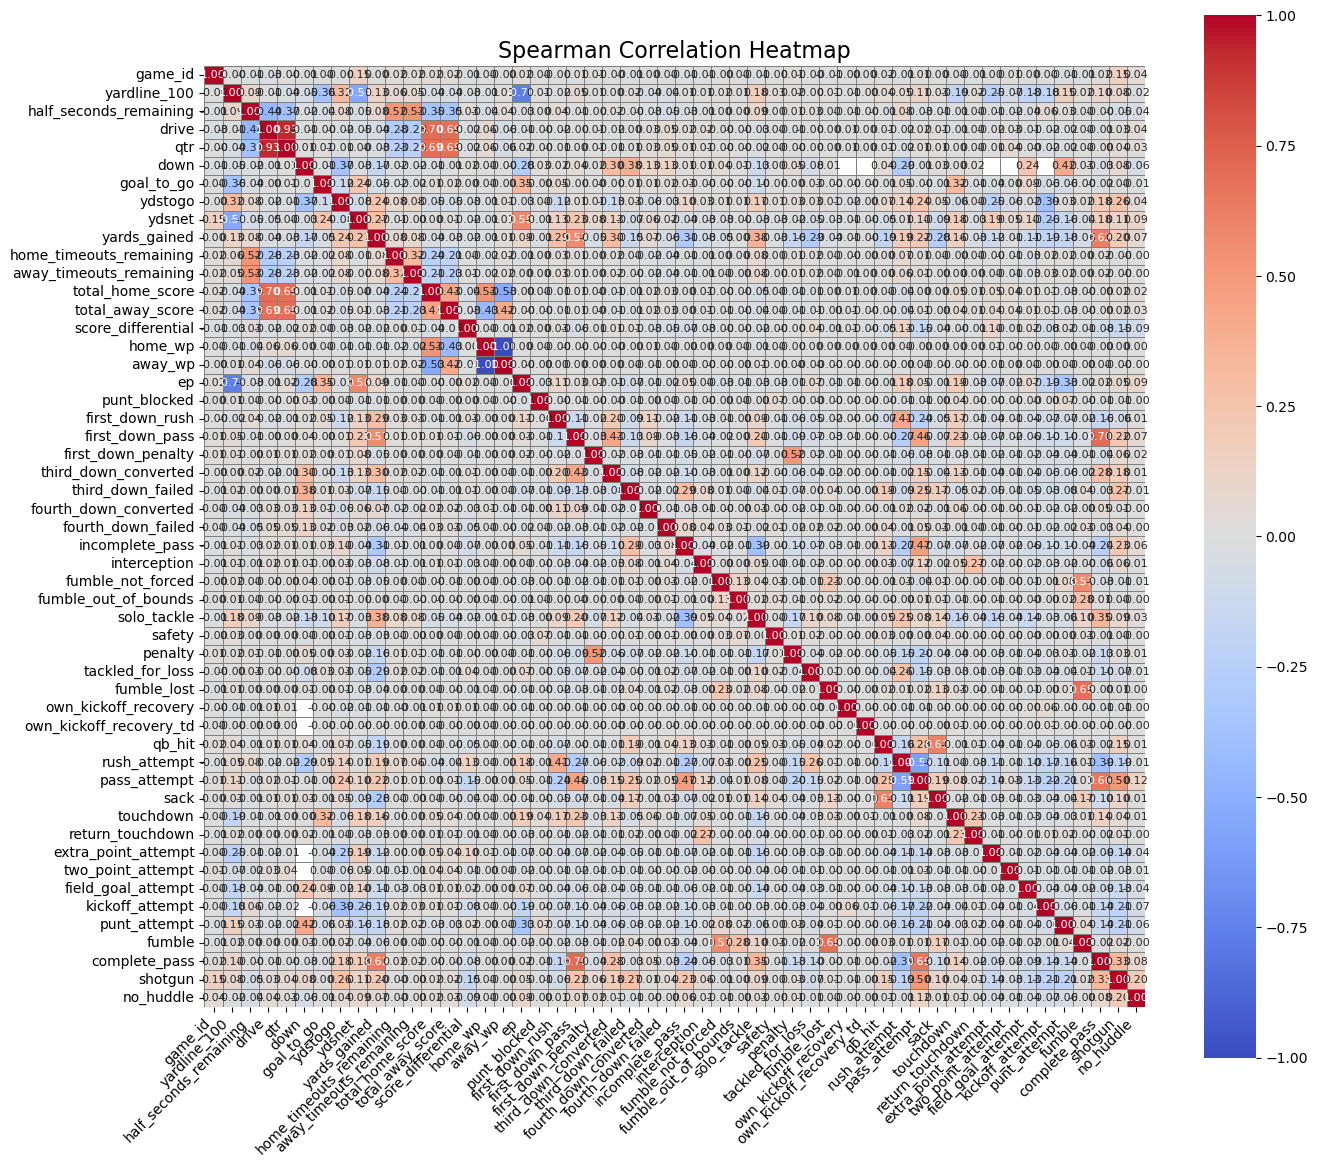

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = dfV4.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr(method='spearman')
threshold = 0.7

correlation_pairs = correlation_matrix.unstack()
correlation_pairs = correlation_pairs[correlation_pairs != 1.0]
strong_positive = correlation_pairs[correlation_pairs > threshold]
strong_negative = correlation_pairs[correlation_pairs < -threshold]

def print_correlations(correlations, title):
    print(f"\n{title}")
    for (feature1, feature2), value in correlations.items():
        print(f"{feature1} and {feature2}: {value:.2f}")

print_correlations(strong_positive, "Strong Positive Correlations")
print_correlations(strong_negative, "Strong Negative Correlations")

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix.round(2),  
            annot=True,
            fmt=".2f",                    
            annot_kws={"size": 8},         
            cmap="coolwarm", 
            center=0, 
            vmin=-1, vmax=1, 
            square=True,                 
            linewidths=0.5,               
            linecolor='gray')

plt.xticks(rotation=45, ha='right', fontsize=10) 
plt.yticks(fontsize=10)                         
plt.title("Spearman Correlation Heatmap", fontsize=16)
plt.tight_layout()                               
plt.show()

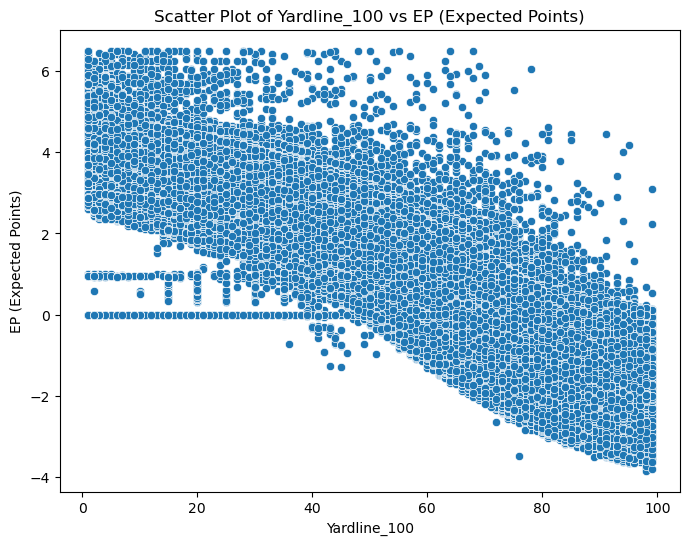

In [38]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='yardline_100', y='ep', data=dfV3)
plt.title('Scatter Plot of Yardline_100 vs EP (Expected Points)')
plt.xlabel('Yardline_100')
plt.ylabel('EP (Expected Points)')
plt.show()

In [39]:
dfV4.describe()

,game_id,yardline_100,half_seconds_remaining,drive,qtr,down,goal_to_go,ydstogo,ydsnet,yards_gained,home_timeouts_remaining,away_timeouts_remaining,total_home_score,total_away_score,score_differential,home_wp,away_wp,ep,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,shotgun,no_huddle
count,4.983930e+05,483527.000000,498234.000000,498393.000000,498393.000000,422609.000000,483950.000000,498393.000000,498393.000000,498180.000000,498393.000000,498393.000000,498393.000000,498393.000000,480943.000000,482515.000000,482515.000000,482929.000000,483763.00000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.00000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,483763.000000,498393.000000,498393.000000
mean,2.014150e+09,49.722146,809.729725,12.233029,2.576669,1.998732,0.050528,7.302378,28.715373,3.903202,2.518846,2.493237,11.984019,10.647266,-1.164712,0.535916,0.463988,1.713844,0.00030,0.069530,0.139159,0.021159,0.059705,0.094381,0.005470,0.005732,0.142419,0.010484,0.004978,0.001191,0.478098,0.000384,0.075206,0.029502,0.00701,0.000207,0.000002,0.056292,0.311921,0.431889,0.027177,0.029486,0.001633,0.025717,0.001685,0.022449,0.059033,0.054514,0.014999,0.250565,0.410746,0.066466
std,3.144108e+06,25.003572,554.939040,7.098878,1.128982,1.005288,0.219032,4.886790,26.345766,7.881064,0.783377,0.803047,10.152589,9.599213,10.873593,0.289899,0.289887,1.746387,0.01731,0.254353,0.346113,0.143915,0.236939,0.292358,0.073754,0.075494,0.349480,0.101856,0.070377,0.034486,0.499521,0.019605,0.263724,0.169209,0.08343,0.014376,0.001438,0.230485,0.463278,0.495340,0.162598,0.169163,0.040378,0.158290,0.041011,0.148139,0.235687,0.227030,0.121549,0.433339,0.491970,0.249094
min,2.009091e+09,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-87.000000,-38.000000,-4.000000,-1.000000,0.000000,0.000000,-59.000000,0.000000,0.000000,-3.836488,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.011121e+09,31.000000,284.000000,6.000000,2.000000,1.000000,0.000000,3.000000,6.000000,0.000000,2.000000,2.000000,3.000000,3.000000,-7.000000,0.318994,0.219611,0.510244,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.014111e+09,52.000000,796.000000,12.000000,3.000000,2.000000,0.000000,9.000000,22.000000,0.000000,3.000000,3.000000,10.000000,9.000000,0.000000,0.535549,0.464350,1.533941,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.017101e+09,71.000000,1287.000000,18.000000,4.000000,3.000000,0.000000,10.000000,49.000000,6.000000,3.000000,3.000000,19.000000,17.000000,

# Notice
## goaltogo and every feature after ep are all binary (0 or 1) and are acting as a boolean/indicator that this type of game dynamic specific play happened
### Below investigating a few columns to understand them better

#### *touchdown: will be 1 on the exact play any team scores a touchdown, not after the play to indicate a touchdown happened
#### *play_type: Has all play types needed, describes play type for the offensive team. **Might want to change NaN values in play_type to no_play, no_play works for penalties and timeouts the NaNs are all just end of quarter or 2-minute warnings time variables where the game is also stopped like the no_play types
#### *drive: Total drives for the game (both teams) ***should make home_drive_no and away_drive_no to differentiate

In [40]:
dfV4[['desc', 'drive', 'play_type', 'touchdown', 'total_home_score', 'total_away_score']].head(200)

,desc,drive,play_type,touchdown,total_home_score,total_away_score
0,"E.Pineiro kicks 65 yards from CHI 35 to end zone, Touchback.",1,kickoff,0.0,0,0
1,(15:00) A.Jones left tackle to GB 25 for no gain (R.Smith).,1,run,0.0,0,0
2,(14:33) A.Rodgers pass short left to A.Jones to GB 25 for no gain (R.Smith).,1,pass,0.0,0,0
3,"(13:45) (Shotgun) A.Rodgers sacked at GB 15 for -10 yards (R.Robertson-Harris). Penalty on GB-L.Taylor, Offensive Holding, declined.",1,pass,0.0,0,0
4,"(13:15) (Punt formation) J.Scott punts 53 yards to CHI 32, Center-H.Bradley. T.Cohen pushed ob at CHI 43 for 11 yards (A.Amos).",1,punt,0.0,0,0
5,"(13:01) (Shotgun) T.Cohen FUMBLES (Aborted) at CHI 37, and recovers at CHI 39. PENALTY on GB-K.Clark, Defensive Holding, 5 yards, enforced at CHI 43 - No Play.",2,no_play,0.0,0,0
6,(12:33) (Shotgun) M.Davis left guard to GB 47 for 5 yards (K.Clark; D.Lowry).,2,run,0.0,0,0
7,(11:58) (Shotgun) M.Trubisky pass incomplete short left to A.Robinson (P.Smith).,2,pass,0.0,0,0
8,(11:54) (Shotgun) M.Trubisky scrambles right tackle to GB 40 for 7 yards (R.Greene).,2,run,0.0,0,0
9,(11:12) (Shotgun) M.Trubisky pass incomplete short left to T.Cohen.,2,pass,0.0,0,0


In [41]:
pd.set_option('display.max_colwidth', None)
dfV4[['desc', 'yards_gained', 'ydsnet' , 'ydstogo', 'yardline_100', 'first_down_rush', 'first_down_pass']].head(200)

,desc,yards_gained,ydsnet,ydstogo,yardline_100,first_down_rush,first_down_pass
0,"E.Pineiro kicks 65 yards from CHI 35 to end zone, Touchback.",0.0,-10,0,35.0,0.0,0.0
1,(15:00) A.Jones left tackle to GB 25 for no gain (R.Smith).,0.0,-10,10,75.0,0.0,0.0
2,(14:33) A.Rodgers pass short left to A.Jones to GB 25 for no gain (R.Smith).,0.0,-10,10,75.0,0.0,0.0
3,"(13:45) (Shotgun) A.Rodgers sacked at GB 15 for -10 yards (R.Robertson-Harris). Penalty on GB-L.Taylor, Offensive Holding, declined.",-10.0,-10,10,75.0,0.0,0.0
4,"(13:15) (Punt formation) J.Scott punts 53 yards to CHI 32, Center-H.Bradley. T.Cohen pushed ob at CHI 43 for 11 yards (A.Amos).",0.0,-10,20,85.0,0.0,0.0
5,"(13:01) (Shotgun) T.Cohen FUMBLES (Aborted) at CHI 37, and recovers at CHI 39. PENALTY on GB-K.Clark, Defensive Holding, 5 yards, enforced at CHI 43 - No Play.",0.0,12,10,57.0,0.0,0.0
6,(12:33) (Shotgun) M.Davis left guard to GB 47 for 5 yards (K.Clark; D.Lowry).,5.0,12,10,52.0,0.0,0.0
7,(11:58) (Shotgun) M.Trubisky pass incomplete short left to A.Robinson (P.Smith).,0.0,12,5,47.0,0.0,0.0
8,(11:54) (Shotgun) M.Trubisky scrambles right tackle to GB 40 for 7 yards (R.Greene).,7.0,12,5,47.0,1.0,0.0
9,(11:12) (Shotgun) M.Trubisky pass incomplete short left to T.Cohen.,0.0,12,10,40.0,0.0,0.0


# NOTICE
## ydsnet = Total yards gained in current plays TOTAL drive length... shows how many yards the offense gains in total for that current drive
## yards_gained = total yards gained in that exact play.... This is the one i was most looking for
## ydstogo = total yards needed to get a first down... ***Definitely useful, 3rd down and 1 ydstogo vs 10 ydstogo vs 30 ydstogo all drastically change game dynamics
## yardline_100 = Exact yard number the current play STARTS at. 99 being the furthest away from the opponents end zone as possible and 1 being as close to the opponents end zone as possible (Team starts on their side of the field, usually around 75 at kickoff)
## first_down_rush and first_down_pass are 1 if the current play resulted in a first down with either a run or pass ***want to combine these

In [42]:
strong_threshold = 0.7
weak_threshold = 0.3
intermediate_threshold = 0.5

correlation_pairs = correlation_matrix.unstack()
correlation_pairs = correlation_pairs[correlation_pairs != 1.0]

strong_positive = correlation_pairs[correlation_pairs > strong_threshold]
intermediate_positive = correlation_pairs[(correlation_pairs > intermediate_threshold) & (correlation_pairs <= strong_threshold)]
weak_positive = correlation_pairs[(correlation_pairs > weak_threshold) & (correlation_pairs <= intermediate_threshold)]
strong_negative = correlation_pairs[correlation_pairs < -strong_threshold]
intermediate_negative = correlation_pairs[(correlation_pairs < -intermediate_threshold) & (correlation_pairs >= -strong_threshold)]
weak_negative = correlation_pairs[(correlation_pairs < -weak_threshold) & (correlation_pairs >= -intermediate_threshold)]

def print_correlations(correlations, title):
    print(f"\n{title}")
    seen_pairs = set()
    for (feature1, feature2), value in correlations.items():
        pair = tuple(sorted([feature1, feature2]))
        if pair not in seen_pairs:
            seen_pairs.add(pair)
            print(f"{feature1} and {feature2}: {value:.2f}")

print_correlations(strong_positive, "Strong Positive Correlations")
print_correlations(strong_negative, "Strong Negative Correlations")
print_correlations(intermediate_positive, "Intermediate Positive Correlations")
print_correlations(intermediate_negative, "Intermediate Negative Correlations")
print_correlations(weak_positive, "Weak Positive Correlations")
print_correlations(weak_negative, "Weak Negative Correlations")


Strong Positive Correlations
drive and qtr: 0.93
drive and total_home_score: 0.70

Strong Negative Correlations
yardline_100 and ep: -0.76
home_wp and away_wp: -1.00

Intermediate Positive Correlations
half_seconds_remaining and home_timeouts_remaining: 0.52
half_seconds_remaining and away_timeouts_remaining: 0.53
drive and total_away_score: 0.69
qtr and total_home_score: 0.69
qtr and total_away_score: 0.68
ydsnet and ep: 0.58
yards_gained and first_down_pass: 0.57
yards_gained and complete_pass: 0.62
total_home_score and home_wp: 0.53
first_down_pass and complete_pass: 0.70
first_down_penalty and penalty: 0.52
fumble_not_forced and fumble: 0.57
fumble_lost and fumble: 0.68
qb_hit and sack: 0.61
pass_attempt and complete_pass: 0.66

Intermediate Negative Correlations
yardline_100 and ydsnet: -0.54
total_home_score and away_wp: -0.53
rush_attempt and pass_attempt: -0.59

Weak Positive Correlations
yardline_100 and ydstogo: 0.32
down and third_down_failed: 0.38
down and punt_attempt: 0.

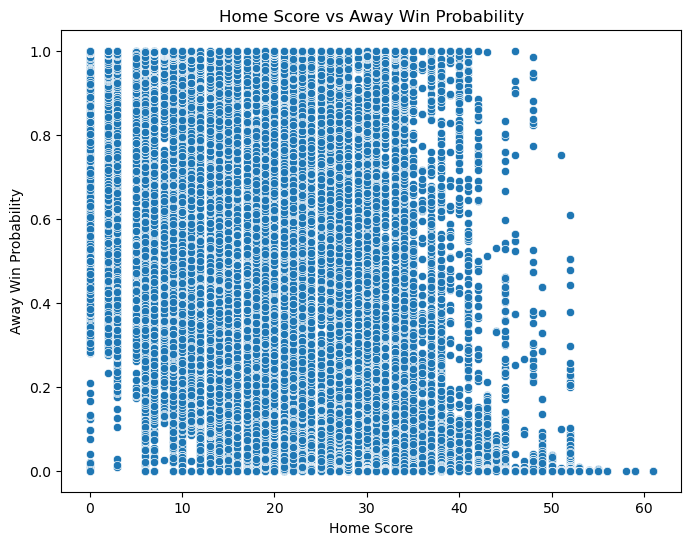

In [43]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_home_score', y='away_wp', data=dfV3)
plt.title('Home Score vs Away Win Probability')
plt.xlabel('Home Score')
plt.ylabel('Away Win Probability')
plt.show()

# At this point its still hard to visualize how certain features affect the win probability while factoring in game dynamics due to the many data points and myself not being the greatest with plotting/graphing. The new features im making based off the data should help seperate and visualize things more clearly, or atleast I hope
## *After the code below, should i remove redundant features once again? for example i made home_td and away_td, so should i get rid of the touchdown indicator?
## *Should make another counter for number of offensive penalties for both teams
## *Should make some type of high_leverage_play indicator, converting on third or fourth down in a tied/1 score difference game with little time remaining
## *Should make another indicator for drought_ending_play: team scoring for the first time on a play after being scored on more than twice in a row

In [45]:
# Indicators for if within last 2 minutes of the half and the whole game
dfV3['close_to_end_of_half'] = (dfV3['half_seconds_remaining'] <= 120).astype(int)
dfV3['close_to_end_of_game'] = ((dfV3['half_seconds_remaining'] <= 120) & (dfV3['game_half'] == 'Half2')).astype(int)

# Indicator for if the touchdown was for the away or home team
dfV3['home_td'] = ((dfV3['touchdown'] == 1) & (dfV3['posteam'] == 'home_team')).astype(int)
dfV3['away_td'] = ((dfV3['touchdown'] == 1) & (dfV3['posteam'] == 'away_team')).astype(int)

# Trackers for the difference in both teams' win probability after each play
dfV3['home_wp_change'] = dfV3['home_wp'].diff().fillna(0)
dfV3['away_wp_change'] = dfV3['away_wp'].diff().fillna(0)

# Indicator for big offensive play
dfV3['big_offensive_play'] = (dfV3['yards_gained'] >= 40).astype(int)

# Indicator for big defensive play
dfV3['big_defensive_play'] = (
    (dfV3['sack'] == 1) |
    (dfV3['tackled_for_loss'] == 1)
).astype(int)

# Indicator for turnover
dfV3['turnover'] = (
    (dfV3['safety'] == 1) |
    (dfV3['interception'] == 1) |
    (dfV3['fumble_lost'] == 1) |
    ((dfV3['fourth_down_converted'] == 0) & (dfV3['down'] == 4))
).astype(int)

# Calculate total drive time in seconds
dfV3['drive_time_seconds'] = dfV3.groupby('drive')['half_seconds_remaining'].transform(lambda x: x.iloc[0] - x.iloc[-1])

# Indicators for long and quick drives
dfV3['long_drive'] = (dfV3['drive_time_seconds'] > 480).astype(int)
dfV3['quick_drive'] = (dfV3['drive_time_seconds'] < 180).astype(int)

# Indicator for long touchdowns
dfV3['long_td'] = ((dfV3['touchdown'] == 1) & (dfV3['yards_gained'] >= 50)).astype(int)

# Trackers for score differentials and lead changes
dfV3['home_score_differential'] = dfV3['total_home_score'] - dfV3['total_away_score']
dfV3['away_score_differential'] = -dfV3['home_score_differential']
dfV3['lead_change'] = ((dfV3['home_score_differential'].diff() < 0) &
                       (dfV3['home_score_differential'].shift() * dfV3['home_score_differential'] < 0)).astype(int)

# New trackers to differentiate drive number for both teams
dfV3['home_drive_number'] = dfV3.groupby((dfV3['posteam'] == 'home_team').cumsum()).cumcount() + 1
dfV3['away_drive_number'] = dfV3.groupby((dfV3['posteam'] == 'away_team').cumsum()).cumcount() + 1

# Combining first down indicators
dfV3['first_down'] = ((dfV3['first_down_pass'] == 1) | (dfV3['first_down_rush'] == 1) | (dfV3['first_down_penalty'] == 1)).astype(int)
dfV3['home_csum_first_downs'] = dfV3['first_down'].where(dfV3['posteam'] == 'home_team').groupby(
    ((dfV3['posteam'] != 'home_team') | (dfV3['turnover'] == 1) | (dfV3['punt_attempt'] == 1)).cumsum()
).cumsum().fillna(0).astype(int)
dfV3['away_csum_first_downs'] = dfV3['first_down'].where(dfV3['posteam'] == 'away_team').groupby(
    ((dfV3['posteam'] != 'away_team') | (dfV3['turnover'] == 1) | (dfV3['punt_attempt'] == 1)).cumsum()
).cumsum().fillna(0).astype(int)

# Counters for consecutive defensive stops
dfV3['home_def_stops'] = ((dfV3['posteam'] != 'home_team') & (dfV3['turnover'] == 0) & (dfV3['touchdown'] == 0) & (dfV3['field_goal_result'] != 'made')).astype(int)
dfV3['home_csum_def_stops'] = dfV3['home_def_stops'].groupby(
    ((dfV3['posteam'] == 'home_team') | (dfV3['touchdown'] == 1) | (dfV3['field_goal_result'] == 'made')).cumsum()
).cumsum().fillna(0).astype(int)
dfV3['away_def_stops'] = ((dfV3['posteam'] != 'away_team') & (dfV3['turnover'] == 0) & (dfV3['touchdown'] == 0) & (dfV3['field_goal_result'] != 'made')).astype(int)
dfV3['away_csum_def_stops'] = dfV3['away_def_stops'].groupby(
    ((dfV3['posteam'] == 'away_team') | (dfV3['touchdown'] == 1) | (dfV3['field_goal_result'] == 'made')).cumsum()
).cumsum().fillna(0).astype(int)

# Indicators for scoring drives
dfV3['home_scoring_drive'] = (
    (dfV3['posteam'] == 'home_team') &
    ((dfV3['field_goal_result'] == 'made') | (dfV3['touchdown'] == 1)) &
    (dfV3['turnover'] == 0) &
    (dfV3['punt_attempt'] == 0)
).astype(int)
dfV3['away_scoring_drive'] = (
    (dfV3['posteam'] == 'away_team') &
    ((dfV3['field_goal_result'] == 'made') | (dfV3['touchdown'] == 1)) &
    (dfV3['turnover'] == 0) &
    (dfV3['punt_attempt'] == 0)
).astype(int)

# Counters for consecutive scoring drives
dfV3['home_csum_scores'] = dfV3['home_scoring_drive'].groupby(
    ((dfV3['posteam'] != 'home_team') | (dfV3['turnover'] == 1) | (dfV3['punt_attempt'] == 1)).cumsum()
).cumsum().fillna(0).astype(int)
dfV3['away_csum_scores'] = dfV3['away_scoring_drive'].groupby(
    ((dfV3['posteam'] != 'away_team') | (dfV3['turnover'] == 1) | (dfV3['punt_attempt'] == 1)).cumsum()
).cumsum().fillna(0).astype(int)

C:\Users\seanz\AppData\Local\Temp\ipykernel_19600\1495096212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfV3['close_to_end_of_half'] = (dfV3['half_seconds_remaining'] <= 120).astype(int)
C:\Users\seanz\AppData\Local\Temp\ipykernel_19600\1495096212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfV3['close_to_end_of_game'] = ((dfV3['half_seconds_remaining'] <= 120) & (dfV3['game_half'] == 'Half2')).astype(int)
C:\Users\seanz\AppData\Local\Temp\ipykernel_19600\1495096212.py:6: SettingWithCopyWar

In [47]:
dfV3[['desc', 'close_to_end_of_half', 'close_to_end_of_game', 'home_td', 'away_td', 
      'home_wp_change', 'away_wp_change', 'big_offensive_play', 'big_defensive_play', 
      'turnover', 'drive_time_seconds', 'long_drive', 'quick_drive', 'long_td', 
      'home_score_differential', 'away_score_differential', 'lead_change', 
      'home_drive_number', 'away_drive_number', 'first_down', 'home_csum_first_downs', 
      'away_csum_first_downs', 'home_def_stops', 'home_csum_def_stops', 'away_def_stops', 
      'away_csum_def_stops', 'home_scoring_drive', 'away_scoring_drive', 
      'home_csum_scores', 'away_csum_scores']].head(200)

,desc,close_to_end_of_half,close_to_end_of_game,home_td,away_td,home_wp_change,away_wp_change,big_offensive_play,big_defensive_play,turnover,drive_time_seconds,long_drive,quick_drive,long_td,home_score_differential,away_score_differential,lead_change,home_drive_number,away_drive_number,first_down,home_csum_first_downs,away_csum_first_downs,home_def_stops,home_csum_def_stops,away_def_stops,away_csum_def_stops,home_scoring_drive,away_scoring_drive,home_csum_scores,away_csum_scores
0,"E.Pineiro kicks 65 yards from CHI 35 to end zone, Touchback.",0,0,0,0,0.000000,0.000000,0,0,0,87.0,0,1,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0,0,0
1,(15:00) A.Jones left tackle to GB 25 for no gain (R.Smith).,0,0,0,0,0.000000,0.000000,0,0,0,87.0,0,1,0,0,0,0,2,2,0,0,0,1,2,1,2,0,0,0,0
2,(14:33) A.Rodgers pass short left to A.Jones to GB 25 for no gain (R.Smith).,0,0,0,0,0.020660,-0.020660,0,0,0,87.0,0,1,0,0,0,0,3,3,0,0,0,1,3,1,3,0,0,0,0
3,"(13:45) (Shotgun) A.Rodgers sacked at GB 15 for -10 yards (R.Robertson-Harris). Penalty on GB-L.Taylor, Offensive Holding, declined.",0,0,0,0,0.026088,-0.026088,0,1,0,87.0,0,1,0,0,0,0,4,4,0,0,0,1,4,1,4,0,0,0,0
4,"(13:15) (Punt formation) J.Scott punts 53 yards to CHI 32, Center-H.Bradley. T.Cohen pushed ob at CHI 43 for 11 yards (A.Amos).",0,0,0,0,0.066931,-0.066931,0,0,1,87.0,0,1,0,0,0,0,5,5,0,0,0,0,4,0,4,0,0,0,0
5,"(13:01) (Shotgun) T.Cohen FUMBLES (Aborted) at CHI 37, and recovers at CHI 39. PENALTY on GB-K.Clark, Defensive Holding, 5 yards, enforced at CHI 43 - No Play.",0,0,0,0,-0.057563,0.057563,0,0,0,382.0,0,0,0,0,0,0,6,6,1,0,0,1,5,1,5,0,0,0,0
6,(12:33) (Shotgun) M.Davis left guard to GB 47 for 5 yards (K.Clark; D.Lowry).,0,0,0,0,0.013391,-0.013391,0,0,0,382.0,0,0,0,0,0,0,7,7,0,0,0,1,6,1,6,0,0,0,0
7,(11:58) (Shotgun) M.Trubisky pass incomplete short left to A.Robinson (P.Smith).,0,0,0,0,0.003330,-0.003330,0,0,0,382.0,0,0,0,0,0,0,8,8,0,0,0,1,7,1,7,0,0,0,0
8,(11:54) (Shotgun) M.Trubisky scrambles right tackle to GB 40 for 7 yards (R.Greene).,0,0,0,0,-0.025898,0.025898,0,0,0,382.0,0,0,0,0,0,0,9,9,1,0,0,1,8,1,8,0,0,0,0
9,(11:12) (Shotgun) M.Trubisky pass incomplete short left to T.Cohen.,0,0,0,0,0.050583,-0.050583,0,0,0,382.0,0,0,0,0,0,0,10,10,0,0,0,1,9,1,9,0,0,0,0


# Notes
## Current problems:
### Quick drive needs to be changed to two features: quick_scoring_drive, and quick_stop. Right now any drive less than 3 minutes is considered a quick drive and this isnt what i intended
### Consecutive stops for home and away is tracking the number of consecutive plays without letting the other team score, want it to be number of drives* without letting the other team score.
### Drive Numbers are tracking number of plays instead of number of drives for both teams
### probably more, need to look at min, max and averages with dfV3.describe/info

## Future Things to investigate with visualizations:
### Differences between quarters for: 
#### number of touchdowns, differences in away_wp and home_wp, remaining timeouts

### Time based series:
#### timeouts remaining (big correlation), scoring in last 2 minutes changes in win probability vs scoring any other time changes in win probability, 

### Close game series:
#### if a team is within 1 score the what happens to wp for: big defensive play, turnover, long drive, etc.

### Game dynamics: 
#### how game flow (scoring trends, big plays, win probability) changes based on current scores, time remaining/quarters, consecutive stops or scores, after big plays, home vs away factors, high-leverage moments (converting 4th or 3rd down with little time remaining), more to think about!